# Amazon Bedrock onboarding notebook

This notebook provides steps requried to install Bedrock SDK, dependencies and other pre-requisistes before API calls can be made.
It also provides sample code to access LLMs, text to image, embeddings and streaming support

All the notebooks in this repo were tested on 

* SageMaker Studio classic ml.m5.2xlarge instance with Datascience 3.0 kernel
* New SageMaker Studio ml.m5.2xlarge instance with Python 3.0 kernel

## Service access checklist
Before you proceed further, ensure following steps are carried out: 

* Ensure that you have access to Amazon Bedrock service in your account and the region you are launching these notebooks
* Review Amazon Bedrock service user guide. You can access the user guide [here.](https://docs.aws.amazon.com/bedrock/latest/userguide/what-is-service.html)
* Subscribe to the models you plan to utilize. This requires subscription to the models from AWS Marketplace for third-party models. If your account is setup with Private Marketplace, you need to subscribe to the model Ids and they need to be part of the Private Marketplace products. Refer to Bedrock User guide for details.
* Enable model access: The account does not have access to models by default. Admin users with IAM access permissions can add access to specific models using the model access page. After the admin adds access to models, those models are available for all users of the account. You will be able to see a message "Access Granted" under Model access page.
* Setup IAM policies to get access to Amazon Bedrock service. You can refer to Bedrock User Guide for a list of actions.

## Pre-requisites

In [1]:
#Check Python version is greater than 3.8 which is required by Langchain if you want to use Langchain
import sys
sys.version

'3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]'

In [2]:
assert sys.version_info >= (3, 8)

## Step 1 - Make sure you have latest boto3 SDK

In [ ]:
!pip install boto3 --upgrade

### Verify boto3 installation

In [ ]:
#!aws bedrock list-foundation-models 
!aws --version

## Step 2- Restart Kernel

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

## Step 3- Attach policies to IAM role to permission Bedrock service

In [3]:
import sagemaker
import boto3
session = boto3.Session()
sagemaker_session = sagemaker.Session()
studio_region = sagemaker_session.boto_region_name 
#sagemaker_session.get_caller_identity_arn()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


First add a policy to the role listed above similar to:
    
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "Bedrock",
            "Effect": "Allow",
            "Action": "bedrock:*",
            "Resource": "*"
        }
    ]
}
```

## Step 4 - Test bedrock boto3 install

In [8]:
# Configure your AWS credentials using the aws configure command, or pass them to the boto3 client
bedrock = boto3.client('bedrock' , 'us-east-1', endpoint_url='https://bedrock.us-east-1.amazonaws.com')
bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': 'b65cfe4f-fa31-4129-afd9-661fef8fb5fa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 16 Jan 2024 21:56:27 GMT',
   'content-type': 'application/json',
   'content-length': '17098',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b65cfe4f-fa31-4129-afd9-661fef8fb5fa'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND'],
   'modelLifecycle': {'status': 'ACTIVE'}},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0',
   'modelId': 'amazon.titan-image-generator-v1:0',
   'modelName': 'Titan Image Generator G1',
   'providerName': 'Amazon',

In [5]:
[m['modelId'] for m in bedrock.list_foundation_models()['modelSummaries']]

['amazon.titan-tg1-large',
 'amazon.titan-image-generator-v1:0',
 'amazon.titan-image-generator-v1',
 'amazon.titan-embed-g1-text-02',
 'amazon.titan-text-lite-v1:0:4k',
 'amazon.titan-text-lite-v1',
 'amazon.titan-text-express-v1:0:8k',
 'amazon.titan-text-express-v1',
 'amazon.titan-embed-text-v1:2:8k',
 'amazon.titan-embed-text-v1',
 'amazon.titan-embed-image-v1:0',
 'amazon.titan-embed-image-v1',
 'stability.stable-diffusion-xl',
 'stability.stable-diffusion-xl-v0',
 'stability.stable-diffusion-xl-v1:0',
 'stability.stable-diffusion-xl-v1',
 'ai21.j2-grande-instruct',
 'ai21.j2-jumbo-instruct',
 'ai21.j2-mid',
 'ai21.j2-mid-v1',
 'ai21.j2-ultra',
 'ai21.j2-ultra-v1',
 'anthropic.claude-instant-v1:2:100k',
 'anthropic.claude-instant-v1',
 'anthropic.claude-v1',
 'anthropic.claude-v2:0:18k',
 'anthropic.claude-v2:0:100k',
 'anthropic.claude-v2:1:18k',
 'anthropic.claude-v2:1:200k',
 'anthropic.claude-v2:1',
 'anthropic.claude-v2',
 'cohere.command-text-v14:7:4k',
 'cohere.command-tex

## Step 5- Test Foundation models 

In [6]:
import json
prompt = """Command: Write me a blog about making strong business decisions as a leader.\nBlog:"""

In [13]:
br = boto3.client('bedrock-runtime')

### Evaluate Titan Large

In [14]:
body = json.dumps({"inputText": prompt})
modelId = "amazon.titan-tg1-large"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("results")[0].get("outputText"))

 Making Strong Business Decisions as a Leader

As a leader, making effective business decisions is critical for the success of your organization. Here are some key strategies to help you make informed and confident decisions:

Define Your Vision: Clearly define your organization's vision, mission, and values. This will provide you with a clear direction of what you want to achieve and guide your decision-making process.

Gather Information: Gather relevant information about the situation, including data, market trends, customer feedback, and internal metrics. This information will help you make informed decisions based on facts rather than assumptions.

Consider Multiple Perspectives:


### Evaluate Anthropic Claude Instant

In [15]:
prompt_formatted = 'Human:\n' + prompt + 'Assistant:\n'
body = json.dumps({"prompt": prompt_formatted, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completion"))

 Here is a draft blog post on making strong business decisions as a leader:

**Making Strong Business Decisions as a Leader** 

As a business leader, one of your most important roles is making important decisions that will impact your company. Whether it's deciding on a new strategic initiative, approving a large capital expenditure, or resolving a conflict between departments, the choices you make can have far-reaching consequences. With so much riding on each decision, it's crucial that leaders develop a thoughtful process for arriving at the best possible outcome. Here are some tips for making strong, well-informed decisions:

**Gather all relevant information.** Don't rush into a decision before understanding all aspects of the issue at hand. Make sure to collect input from various stakeholders, review necessary documents and data, and identify potential risks and opportunities. Taking the time up front to become fully educated will allow you to make a decision from a position of k

### Evaluate AI21 Jurassic Grande

In [16]:
body = json.dumps({"prompt": prompt, "maxTokens": 200})
modelId = "ai21.j2-grande-instruct"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completions")[0].get("data").get("text"))



As a leader, it is important to constantly be making difficult decisions. Many of these decisions can be the difference between success and failure for an organization. However, making strong decisions is not necessarily easy. It takes patience, persistence, and the ability to weigh the pros and cons of each option.

Here are a few tips for making strong business decisions as a leader:

1. Gather information: Before making a decision, it is important to gather as much information as possible. This can involve conducting research, analyzing data, and talking to stakeholders.
2. Consider your options: Once you have gathered information, it is important to consider your options carefully. This can involve making a pros and cons list, consulting with your team, and weighing the possible outcomes of each option.
3. Make a decision: Once you have considered your options, it is time to make a decision. It is important to make a decision that is in the best interest of the organization and i

### Evaluate Cohere Command Text V14.6

In [17]:
body = json.dumps({"prompt": prompt, "max_tokens": 500})
modelId = "cohere.command-text-v14"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("generations")[0].get("text"))

 As a leader, making strong business decisions is an essential part of your role. It can be a challenging task, but with the right tools and mindset, you can make informed and effective decisions that will help your business thrive. Here are some tips to help you make strong business decisions:

1. Gather all the relevant information: Before making a decision, it's important to gather all the relevant information and data that will help you make an informed decision. This may include market research, financial data, customer feedback, and other information that will help you understand the situation and potential outcomes of your decision.

2. Consider multiple perspectives: It's important to consider multiple perspectives when making a decision, including the perspectives of your team, stakeholders, and customers. This can help you gain a more comprehensive understanding of the situation and potential outcomes.

3. Seek input from others: It's often helpful to seek input from others w

### Evaluate Titan Embeddings

In [19]:
body = json.dumps({"inputText": prompt})
modelId = "amazon.titan-embed-text-v1"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

embedding = response_body.get("embedding")
print(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

The embedding vector has 1536 values
[0.32226562, -0.30664062, -0.27539062, '...', -0.14160156, -0.6484375, -0.26367188]


### Evaluate Stable Diffusion Model

In [20]:
prompt_data = "a fine image of an astronaut riding a horse on Mars"
body = json.dumps({
  "text_prompts": [
    { 
      "text": prompt_data 
    }
  ],
  "cfg_scale":10,
  "seed":20,
  "steps":50
})
modelId = "stability.stable-diffusion-xl" 
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body['result'])
print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAABrGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


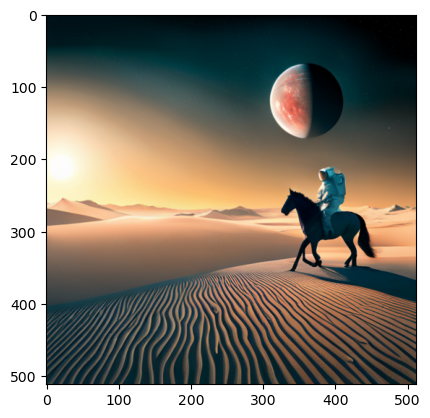

In [21]:
import io, base64
from matplotlib.pyplot import imshow
from PIL import Image
base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
imshow(image)

### Streaming Response

In [22]:
from IPython.display import display, display_markdown, Markdown, clear_output

prompt = """Command: Write me a blog about making strong business decisions as a leader.\nBlog:"""
prompt_formatted = 'Human:\n' + prompt + 'Assistant:\n'


body = json.dumps({"prompt": prompt_formatted, "max_tokens_to_sample": 200})
modelId = "anthropic.claude-instant-v1"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model_with_response_stream(body=body, modelId=modelId, accept=accept, contentType=contentType)
stream = response.get('body')
output = []

if stream:
    for event in stream:
        chunk = event.get('chunk')
        if chunk:
            chunk_obj = json.loads(chunk.get('bytes').decode())
            text = chunk_obj['completion']
            clear_output(wait=True)
            output.append(text)
            display_markdown(Markdown(''.join(output)))

 Here is a draft blog post on making strong business decisions as a leader:

**How to Make Strong Business Decisions as a Leader**

As a leader, one of your most important responsibilities is making decisions that help guide your business in the right direction. However, making the right call is not always easy - there are often multiple factors to consider and outcomes that are uncertain. Here are some tips for making strong decisions that will have a positive impact on your business:

**Gather Quality Data and Insights.** Before deciding on a course of action, take the time to collect as much relevant information as possible. Talk to customers, partners, employees and industry experts. Review past performance metrics and sales reports. Having a solid understanding of the current landscape and potential impacts will allow you to make an informed choice. 

**Consider Multiple Options.** Don't feel pressured to make a quick decision. Brainstorm alternative approaches and weigh the pros and cons of each. Getting input from your